## 纯位置控制与位置速度控制对比

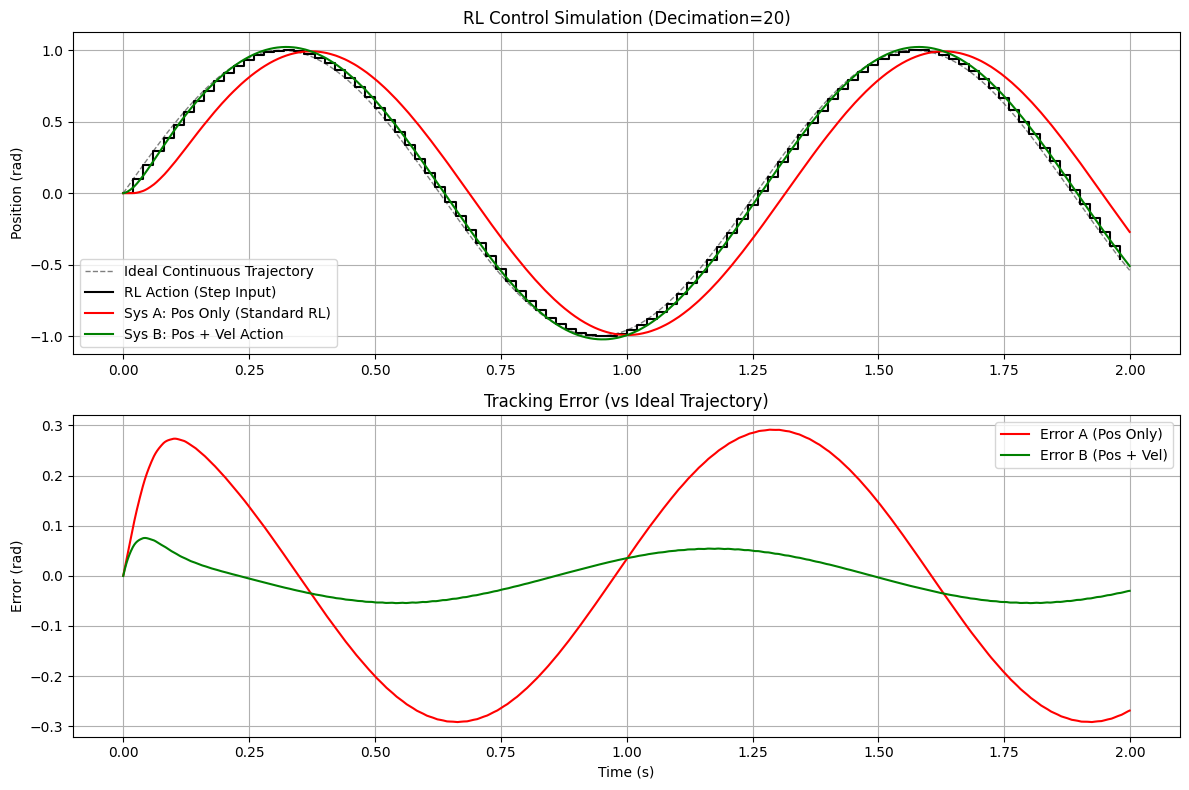

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 仿真设置
sim_dt = 0.001       # 物理步长 1ms (1000Hz)
decimation = 20      # 决策间隔 (20ms, 50Hz Control) - 模拟 RL 的控制频率
total_time = 2.0     # 总时间
t = np.arange(0, total_time, sim_dt)

# 2. 定义理想轨迹 (Ground Truth Trajectory)
# 我们希望机器人画出的完美曲线
theta_ideal = np.sin(5 * t)
theta_dot_ideal = 5 * np.cos(5 * t)

# 3. 定义 RL 策略输出的目标 (模拟 Zero-Order Hold)
# 在 RL 中，动作在每个环境步(env_step)开始时确定，并在整个 decimation 期间保持不变
# 这意味着物理引擎看到的 target 是一个阶梯状的信号
theta_d_rl = np.zeros_like(t)
theta_dot_d_rl = np.zeros_like(t)

current_target_pos = theta_ideal[0]
current_target_vel = theta_dot_ideal[0]

for i in range(len(t)):
    if i % decimation == 0:
        # 策略更新时刻：采样理想轨迹作为新的 Action
        current_target_pos = theta_ideal[i]
        current_target_vel = theta_dot_ideal[i]
    
    theta_d_rl[i] = current_target_pos
    theta_dot_d_rl[i] = current_target_vel

# 4. 物理参数
Inertia = 0.1   # 转动惯量
Kp = 100.0      # 刚度
Kd = 5.0        # 阻尼

# 5. 仿真循环
# System A: Standard RL (Pos Only) 
# 只有阶梯状的位置目标，速度目标默认为 0 (因为是 Setpoint，我们希望它停在那里)
theta_A = 0.0
theta_dot_A = 0.0
history_A = []

# System B: RL with Velocity Output 
# 阶梯状的位置目标 + 阶梯状的速度目标 (告诉 PD 控制器这个阶梯其实是有速度的)
theta_B = 0.0
theta_dot_B = 0.0
history_B = []

for i in range(len(t)):
    # --- System A (Standard RL: Pos Action Only) ---
    # 误差 = (当前固定的目标位置 - 实时位置)
    # 阻尼项 = (0 - 实时速度) -> Kd 试图阻碍运动，让关节停在目标点
    error_pos_A = theta_d_rl[i] - theta_A
    error_vel_A = 0.0 - theta_dot_A  # 关键区别：没有速度前馈，Kd * (0 - v)
    tau_A = Kp * error_pos_A + Kd * error_vel_A
    
    acc_A = tau_A / Inertia
    theta_dot_A += acc_A * sim_dt
    theta_A += theta_dot_A * sim_dt
    history_A.append(theta_A)

    # --- System B (RL with Velocity Action) ---
    # 误差 = (当前固定的目标位置 - 实时位置)
    # 阻尼项 = (当前固定的目标速度 - 实时速度) -> Kd 试图让关节速度匹配目标速度
    error_pos_B = theta_d_rl[i] - theta_B
    error_vel_B = theta_dot_d_rl[i] - theta_dot_B 
    tau_B = Kp * error_pos_B + Kd * error_vel_B
    
    acc_B = tau_B / Inertia
    theta_dot_B += acc_B * sim_dt
    theta_B += theta_dot_B * sim_dt
    history_B.append(theta_B)

# 6. 绘图
plt.figure(figsize=(12, 8))

# 绘制轨迹
plt.subplot(2, 1, 1)
plt.plot(t, theta_ideal, 'k--', linewidth=1, alpha=0.5, label='Ideal Continuous Trajectory')
plt.step(t[::decimation], theta_d_rl[::decimation], 'k-', where='post', linewidth=1.5, label='RL Action (Step Input)')
plt.plot(t, history_A, 'r-', linewidth=1.5, label='Sys A: Pos Only (Standard RL)')
plt.plot(t, history_B, 'g-', linewidth=1.5, label='Sys B: Pos + Vel Action')
plt.title(f'RL Control Simulation (Decimation={decimation})')
plt.ylabel('Position (rad)')
plt.legend()
plt.grid(True)

# 绘制误差
plt.subplot(2, 1, 2)
plt.plot(t, theta_ideal - history_A, 'r-', label='Error A (Pos Only)')
plt.plot(t, theta_ideal - history_B, 'g-', label='Error B (Pos + Vel)')
plt.title('Tracking Error (vs Ideal Trajectory)')
plt.xlabel('Time (s)')
plt.ylabel('Error (rad)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()